# Forecast Maximum Rainfall 

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


### Plot Entire Data

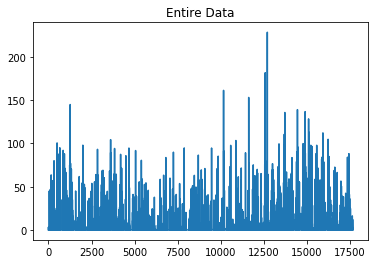

In [3]:
plt.plot(rainfall_df['..R/F'].to_numpy())
plt.title('Entire Data')
plt.show()

## Computing Monthly Max Rainfall

In [4]:
print(rainfall_df['..R/F'].to_numpy()[16001])

30.1


Data Type: float64, Data Shape: (580,)

First 10 data points:
[3.2, 45.0, 0.0, 47.0, 25.2, 63.6, 39.0, 57.0, 27.0, 30.0]

Last 10 data points:
[58.0, 54.2, 88.2, 41.1, 15.2, 24.8, 0.0, 12.6, 14.8, 16.2]


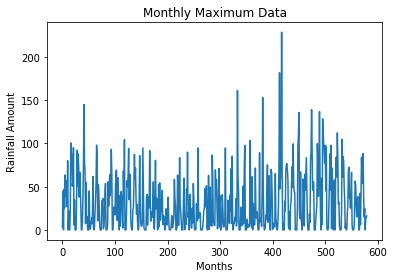

In [5]:
month_max_series = [rainfall_df.iloc[0]['..R/F']]
prev_month = rainfall_df.iloc[0]['MN']

for _, row in rainfall_df.iloc[1:].iterrows():
    
    if row['MN'] == prev_month:
        month_max_series[-1] = max(month_max_series[-1], row['..R/F'])
        
    else:
        month_max_series.append(row['..R/F'])
        
    prev_month = row['MN']
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

In [6]:
train_frac = 0.85
n = month_max_series.shape[0]
num_train = int(n * train_frac)

print(f'Train Size: {num_train}, Test Size: {n - num_train}')

Train Size: 493, Test Size: 87


## Decompose the time series into trend, seasonality and remainder components

In [7]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [8]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

### Plot Time Series Components

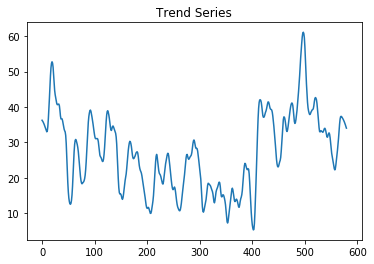

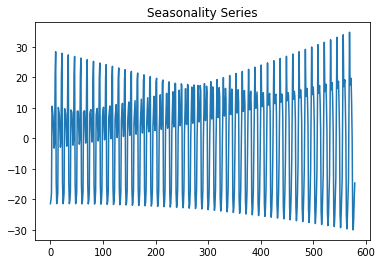

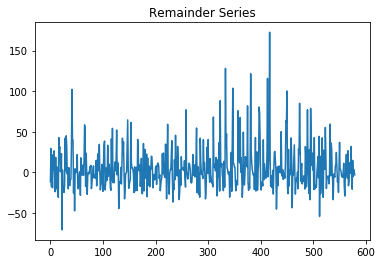

In [9]:
plt.plot(trend_series)
plt.title('Trend Series')
plt.show()

plt.plot(seasonality_series)
plt.title('Seasonality Series')
plt.show()

plt.plot(remainder_series)
plt.title('Remainder Series')
plt.show()

### Compare the inferred seasonality with actual data

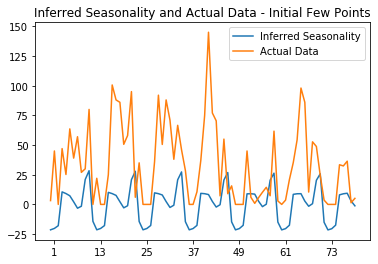

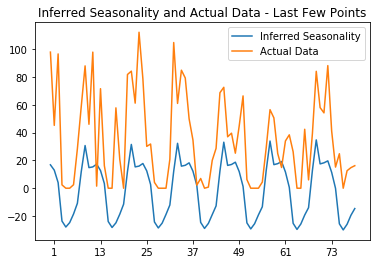

In [10]:
# Front Few Points
num_initial_points = 80

plt.plot(seasonality_series[:num_initial_points], label='Inferred Seasonality')
plt.plot(month_max_series[:num_initial_points], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.xticks(np.arange(1, num_initial_points, 12))
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(seasonality_series[-num_last_points:], label='Inferred Seasonality')
plt.plot(month_max_series[-num_last_points:], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.xticks(np.arange(1, num_last_points, 12))
plt.show()

## Parameter Estimation of GEV fitted to Remainder Series

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: -0.02496203270353183 
Location Parameter: -6.2328106355581205 
Scale Parameter: 20.655595377829776 
Log Likelihood: -2256.204376911155


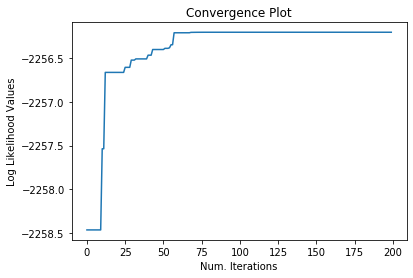

In [11]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [12]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

### Plot PDF and CDF

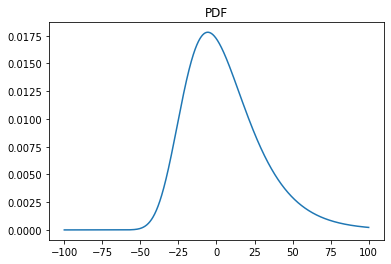

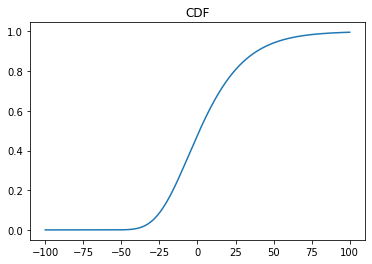

In [13]:
x = np.linspace(-100, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

## Compute CDF of each data point in remainder series

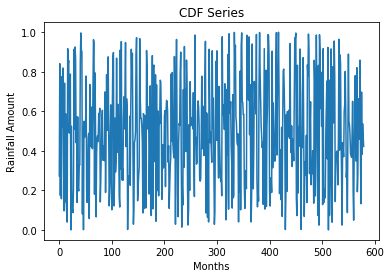

In [40]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## Model for Forecasting next day CDF

### Model Architecture

In [32]:
lag = 50

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [33]:
input_data = []
output_data = []

for i in range(lag + 1, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (442, 50)
Output Data Shape: (442, 1)


Epoch 1/100
14/14 [==============================] - 0s 841us/step - loss: 0.0707
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0691
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0682
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0636
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0604
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0577
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0568
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 12/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0625
Epoch 13/100
14/14 [===============

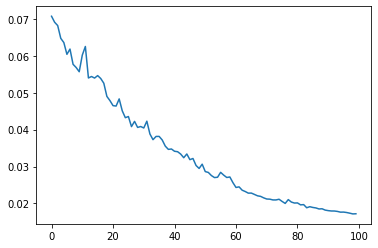

In [34]:
history = model.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

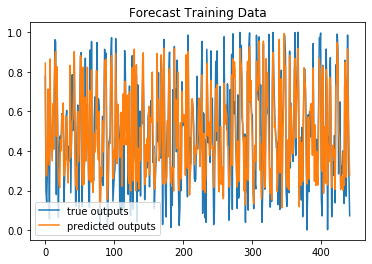

In [47]:
remainder_train_cdf = model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(output_data, label='true outputs')
plt.plot(remainder_train_cdf, label='predicted outputs')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

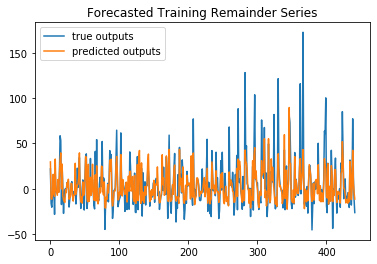

In [48]:
plt.plot(remainder_series[lag + 1: num_train], label='true outputs')
plt.plot(remainder_train, label='predicted outputs')
plt.legend()
plt.title('Forecasted Training Remainder Series')
plt.show()

### Forecast test data

In [36]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


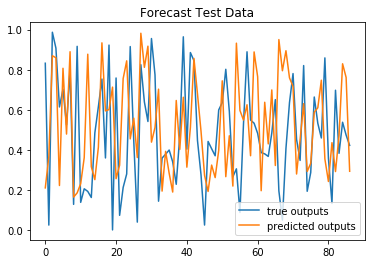

In [49]:
remainder_test_cdf = model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(test_output, label='true outputs')
plt.plot(remainder_test_cdf, label='predicted outputs')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

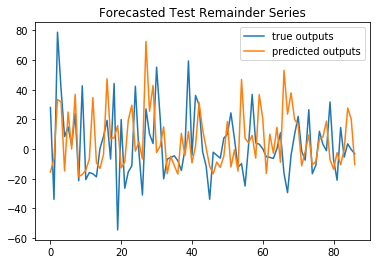

In [50]:
plt.plot(remainder_series[num_train:], label='true outputs')
plt.plot(remainder_test, label='predicted outputs')
plt.legend()
plt.title('Forecasted Test Remainder Series')
plt.show()

## Forecasting Trend

### Model Architecture

In [21]:
lag = 50

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [22]:
input_data = []
output_data = []

for i in range(lag + 1, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (442, 50)
Output Data Shape: (442, 1)


Epoch 1/100
14/14 [==============================] - 0s 885us/step - loss: 362.0869
Epoch 2/100
14/14 [==============================] - 0s 835us/step - loss: 58.8456
Epoch 3/100
14/14 [==============================] - 0s 789us/step - loss: 40.6556
Epoch 4/100
14/14 [==============================] - 0s 782us/step - loss: 23.9438
Epoch 5/100
14/14 [==============================] - 0s 785us/step - loss: 16.6464
Epoch 6/100
14/14 [==============================] - 0s 808us/step - loss: 14.9115
Epoch 7/100
14/14 [==============================] - 0s 773us/step - loss: 11.2413
Epoch 8/100
14/14 [==============================] - 0s 750us/step - loss: 8.2923
Epoch 9/100
14/14 [==============================] - 0s 765us/step - loss: 6.4384
Epoch 10/100
14/14 [==============================] - 0s 752us/step - loss: 7.1998
Epoch 11/100
14/14 [==============================] - 0s 756us/step - loss: 6.4487
Epoch 12/100
14/14 [==============================] - 0s 851us/step - loss: 5.4043
Epoch

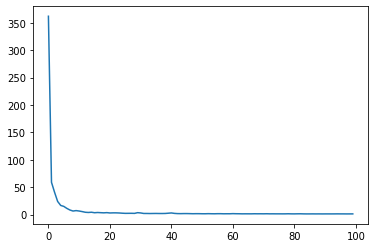

In [23]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

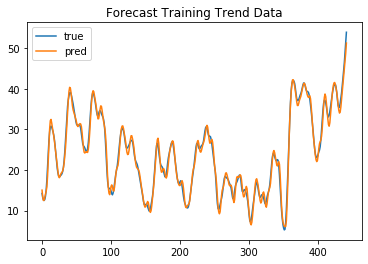

In [24]:
trend_train = model_trend.predict(input_data)

plt.plot(output_data, label='true outputs')
plt.plot(trend_train, label='predicted outputs')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

### Forecast test data

In [25]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


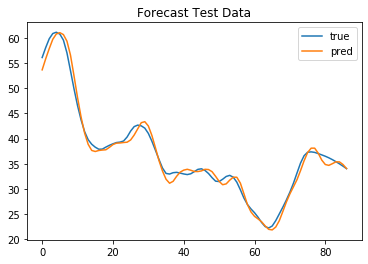

In [26]:
trend_test = model_trend.predict(test_input)

plt.plot(test_output, label='true')
plt.plot(trend_test, label='pred')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Seasonality

### Forecast training data

In [27]:
seasonality_train = seasonality_series[:num_train][lag + 1:]

### Forecast test data

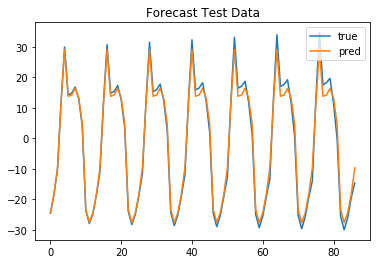

In [28]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(seasonality_series[num_train:], label='true')
plt.plot(seasonality_test, label='pred')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecast Maximum Rainfall

In [29]:
print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(442, 1) (442, 1) (442, 1)
(87, 1) (87, 1) (87, 1)


### Forecast training data

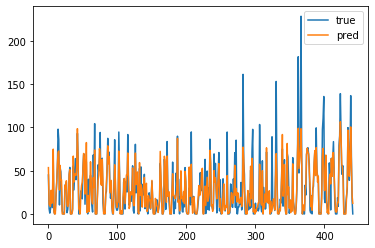

In [51]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag + 1:]

plt.plot(true_train, label='true')
plt.plot(pred_train, label='pred')
plt.legend()
plt.show()

### Forecast test data

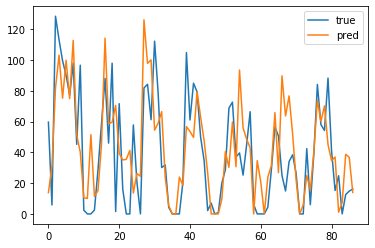

In [52]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(true_test, label='true')
plt.plot(pred_test, label='pred')
plt.legend()
plt.show()